In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.preprocessing import OneHotEncoder
from sksurv.metrics import concordance_index_censored
from google.oauth2 import service_account
import pandas_gbq as gbq


In [116]:
df = pd.read_csv('dataset/X_Y_merged.csv')
df.head()
# credentials_path = 'token.json'

# # Authenticate with your credentials
# credentials = service_account.Credentials.from_service_account_file(
#     credentials_path, scopes=['https://www.googleapis.com/auth/bigquery'])

# # Set the credentials for pandas_gbq
# gbq.context.credentials = credentials

# project_id = 'capstone-398012'
# dataset_id = 'capstone'
# table_id = "filled_table_2"

# from pandas_gbq import read_gbq

# query = f"""
# SELECT *
# FROM `{project_id}.{dataset_id}.{table_id}`

# """

# # Authenticate and read data from BigQuery into a DataFrame
# df = read_gbq(query, project_id=project_id, dialect='standard')
# df.head()


,CompNo,yyyy,mm,StkIndx,STInt,dtdlevel,dtdtrend,liqnonfinlevel,liqnonfintrend,ni2talevel,...,sigma,liqfinlevel,lqfintrend,DTDmedianFin,DTDmedianNonFin,dummy297fin,EventDate,Event_type,Sector_Number,Exchange
0,15984,1999,3,0.167570,0.006248,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,0.0,0.0,2.324205,0,199903,0,12.0,15
1,15984,1999,4,0.200972,0.006487,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,0.0,0.0,2.373554,0,199904,2,17.0,15
2,15984,1999,6,0.210673,0.007457,NaN,NaN,0.447325,0.000000e+00,0.00932,...,0.276896,0.0,0.0,0.0,2.455890,0,199906,2,12.0,15
3,15984,1999,9,0.261256,0.007744,4.779150,0.100454,0.447325,0.000000e+00,0.00932,...,0.238643,0.0,0.0,0.0,2.499298,0,199909,2,99.0,15
4,15984,2000,1,0.089239,0.011089,4.966794,-0.019877,0.447325,-5.550000e-17,0.00932,...,0.219866,0.0,0.0,0.0,2.630245,0,200001,2,19.0,15


In [117]:
# drop data when year less than 1999
# df = data[data['yyyy'] >= 1999]

df['transformed_status'] = df['Event_type'].map(lambda x : 1 if x == 1 else 0)
df['transformed_year'] = df['yyyy'].apply(lambda x: x - 1988)

# Data preprocessing
X = df.drop(['EventDate','Event_type', 'Sector_Number', 'Exchange'], axis=1)  # Features

# X = df.drop(['EventDate_notNA','Event_type', 'Sector_Number_notNA', 'Exchange_notNA'], axis=1)  # Features
y = df['Event_type']  # Target

df.head()

,CompNo,yyyy,mm,StkIndx,STInt,dtdlevel,dtdtrend,liqnonfinlevel,liqnonfintrend,ni2talevel,...,lqfintrend,DTDmedianFin,DTDmedianNonFin,dummy297fin,EventDate,Event_type,Sector_Number,Exchange,transformed_status,transformed_year
0,15984,1999,3,0.167570,0.006248,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,2.324205,0,199903,0,12.0,15,0,11
1,15984,1999,4,0.200972,0.006487,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,2.373554,0,199904,2,17.0,15,0,11
2,15984,1999,6,0.210673,0.007457,NaN,NaN,0.447325,0.000000e+00,0.00932,...,0.0,0.0,2.455890,0,199906,2,12.0,15,0,11
3,15984,1999,9,0.261256,0.007744,4.779150,0.100454,0.447325,0.000000e+00,0.00932,...,0.0,0.0,2.499298,0,199909,2,99.0,15,0,11
4,15984,2000,1,0.089239,0.011089,4.966794,-0.019877,0.447325,-5.550000e-17,0.00932,...,0.0,0.0,2.630245,0,200001,2,19.0,15,0,12


Text(0.5, 0, 'time $t$')

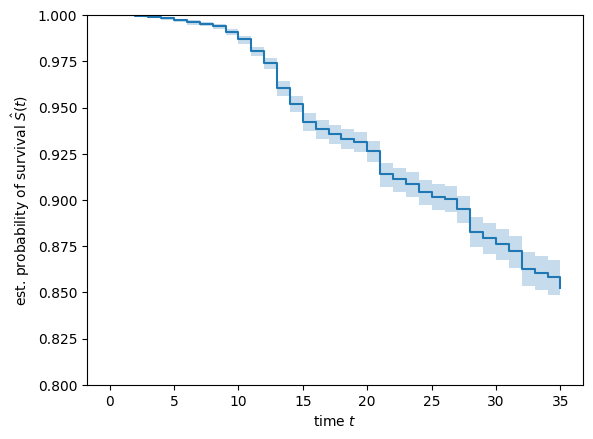

In [118]:
# Kaplan meier estimator
df['status_boolean'] = df['transformed_status'].map(lambda x : True if x == 1 else False)

time, survival_prob, conf_int = kaplan_meier_estimator(
    df["status_boolean"], df["transformed_year"], conf_type="log-log"
)

plt.step(time, survival_prob, where="post")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylim(0.8, 1)
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

In [119]:
# Data preprocessing
# X = df.drop(['yyyy', 'EventDate_notNA','Event_type', 'Sector_Number_notNA', 'Exchange_notNA', 'transformed_status','transformed_year', 'status_boolean'], axis=1)  # Features

X = df.drop(['yyyy', 'EventDate','Event_type', 'Sector_Number', 'Exchange', 'transformed_status','transformed_year', 'status_boolean'], axis=1)  # Features
y = np.array(list(zip(df['status_boolean'], df['transformed_year'])), dtype=[('event', bool), ('time', int)])

encoder = OneHotEncoder()
X_encoded = encoder.fit_transform(X)

# Imputing Nan
X_encoded = X_encoded.fillna(0)

# Scaling
scaler = StandardScaler()
#  = scaler.fit_transform(X)
X_encoded = scaler.fit_transform(X_encoded) 

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [120]:
estimator = CoxPHSurvivalAnalysis()
estimator.fit(X_train, y_train)


CoxPHSurvivalAnalysis()

In [121]:
prediction = estimator.predict(X_test)

y_df = pd.DataFrame(y_test)

result = concordance_index_censored(y_df['event'], y_df['time'], prediction)
# or estimator.score(X_test, y_test)
print(f"Concordance Index: {result[0]}")

Concordance Index: 0.7607796777918293
